# __Desafío - Máquinas de Soporte Vectorial__

## Requerimientos
Para esta sesión trabajaremos con la base de datos sobre cáncer mamario de Wisconsin. El
objetivo es desarrollar un Clasificador mediante Máquinas de Soporte de Vectores que predica
de forma adecuada en base a una serie de atributos sobre la composición del núcleo de una
célula mamaria. Para más detalles técnicos asociados a la base de datos, pueden hacer click
en el [link](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names).

## Ejercicio 1: Preparar el ambiente de trabajo
- Importe todas las librerías a utilizar.
- Fije los parámetros de los gráficos con `plt.Rcparams`.
- Excluya las columnas `id` y `Unnamed: 32` de la base de datos.
- Recodifique el vector objetivo `diagnosis` a numérico para poder procesarlo
posteriormente.

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
# Se usara figsize en subplots en vez de plt.rcParams

In [6]:
df = pd.read_csv('breast_cancer.csv').drop(columns=['Unnamed: 32', 'id'])
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [10]:
# Recodificamos
lbl = LabelEncoder()
df['diagnosis_m'] = lbl.fit_transform(df['diagnosis'])
refactoredDf = df.drop(columns=['diagnosis'])
# Imprimimos las columnas y sus tipos
print(df.dtypes)

diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst

## Ejercicio 2: Visualizando la distribución de los atributos
- Para cada uno de los atributos, grafique los histogramas condicional a cada clase del
vector objetivo.
- Agregue las medias correspondientes y reporte a grandes rasgos cuáles son los
atributos con una mayor similitud en la distribución.

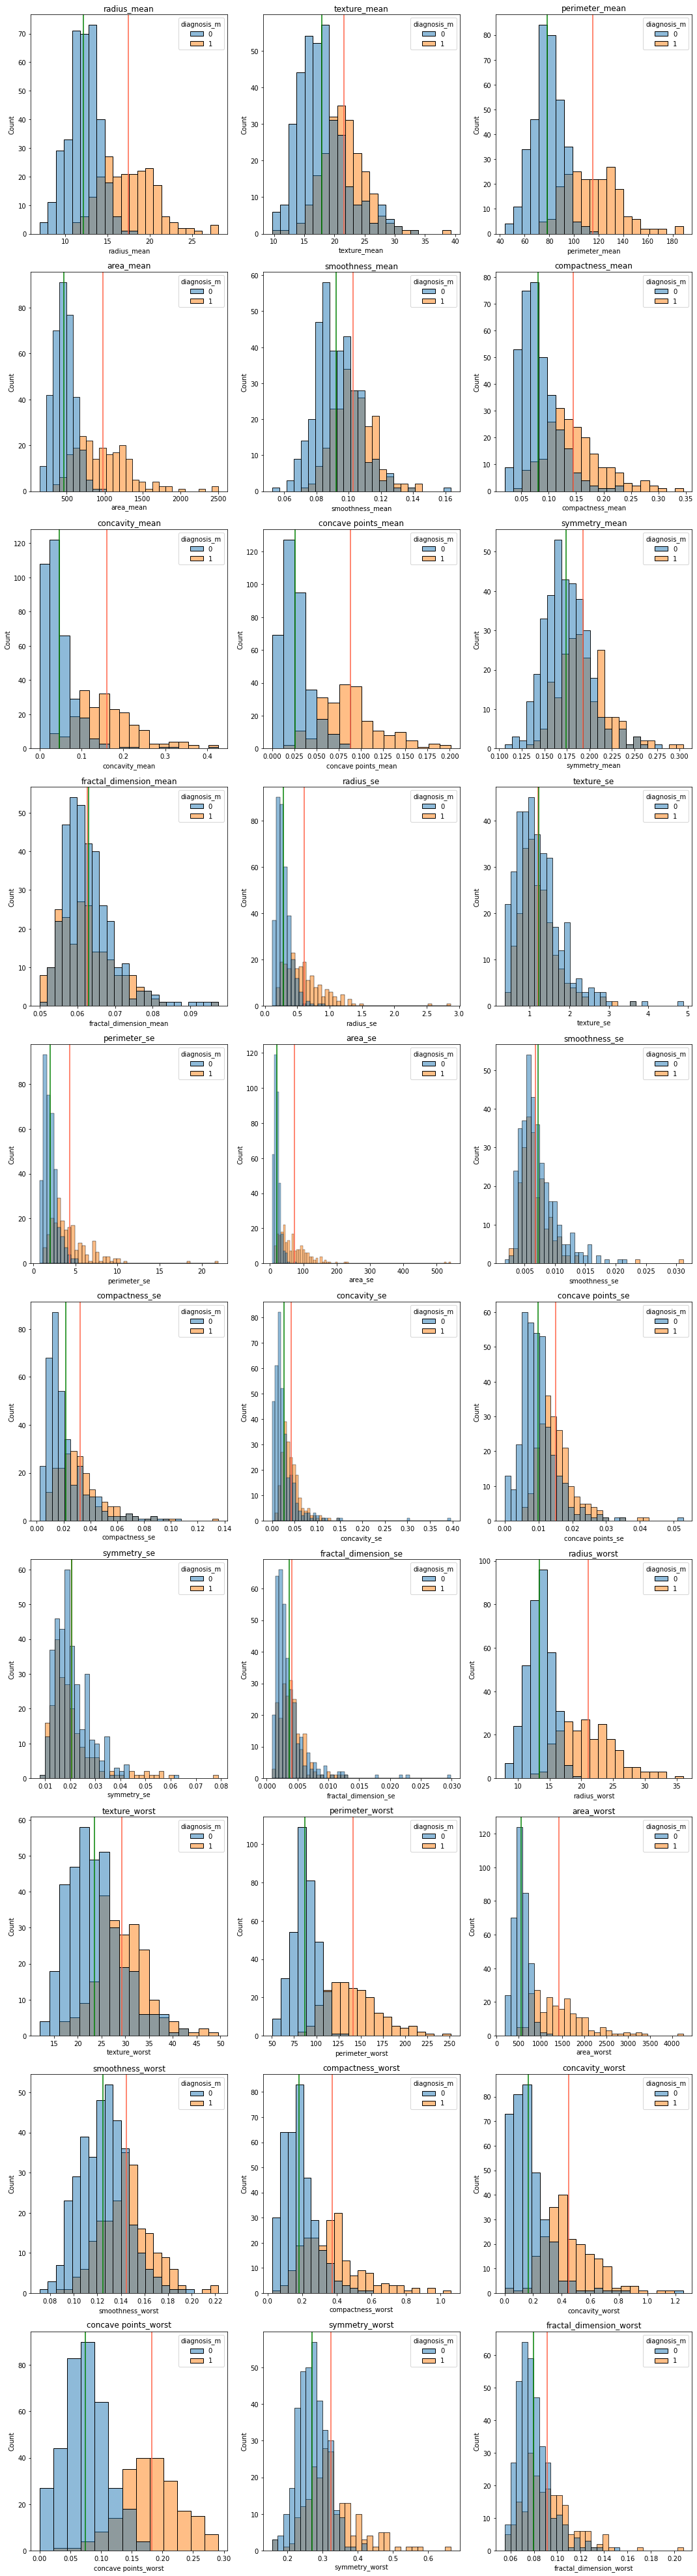

In [20]:
fig, ax = plt.subplots(10, 3, figsize=(15, 55))
axes = ax.flatten()
for i, (col, serie) in enumerate(refactoredDf.iteritems()):
    if serie.dtype == 'float64':
        # Graficamos el histograma
        sns.histplot(x=col, hue='diagnosis_m', data=refactoredDf, ax=axes[i])
        # añadimos el título
        axes[i].set_title(col)
        # añadimos las lineas para las medias de cada clase.
        axes[i].axvline(refactoredDf[refactoredDf['diagnosis_m'] == 1][col].mean(), color='tomato')
        axes[i].axvline(refactoredDf[refactoredDf['diagnosis_m'] == 0][col].mean(), color='green')

plt.tight_layout()

Los atributos que se mantienen parecidos para ambos tipos de tumores son:
- `symmetry_se`
- `fractal_dimension_se`
- `fractal_dimension_mean`
- `smoothness_se`
- `texture_se`

## Ejercicio 3: Estimando el porcentaje de overlap en los atributos
- Parte de las virtudes de las Máquinas de Soporte Vectorial es la capacidad de lidiar con
clases no separables mediante el proceso de kernelización. Resulta que un aspecto
importante que muchas veces se obvia es medir la noseparabilidad de los atributos,
condicional a cada clase del vector objetivo.
- El procedimiento para estimar el rango de noseparabilidad entre clases se implementa
en Python de la siguiente manera:
```python
def histogram_overlap(df, attribute, target, perc=100):
    # get lower bound
    empirical_lower_bound = np.floor(df[attribute].min())
    # get upper bound
    empirical_upper_bound = np.ceil(df[attribute].max())
    # preserve histograms
    tmp_hist_holder = dict()
    # for each target class
    for unique_value in np.unique(df[target]):
        # get histogram
        tmp, _ = np.histogram(
        # for a specific attribute
        df[df[target] == unique_value][attribute],
        # define percentage
        bins=perc,
        # limit empirical range for comparison
        range=[empirical_lower_bound, empirical_upper_bound])
        # append to dict
        tmp_hist_holder["h_"+str(unique_value)] = tmp
    get_minima = np.minimum(tmp_hist_holder["h_1"], tmp_hist_holder["h_0"])
    intersection = np.true_divide(np.sum(get_minima), np.sum(tmp_hist_holder["h_0"]))
    return intersection
```
- La intersección devolverá el porcentaje de comunalidad entre ambas clases, donde
mayores niveles indican una mayor comunalidad.
- Utilizando la función, generará un data frame donde almacenará el nombre del atributo y
su porcentaje. Ordene este data frame de forma descendente y preserve.


In [23]:
def histogram_overlap(df, attribute, target, perc=100):
    # get lower bound
    empirical_lower_bound = np.floor(df[attribute].min())
    # get upper bound
    empirical_upper_bound = np.ceil(df[attribute].max())
    # preserve histograms
    tmp_hist_holder = dict()
    # for each target class
    for unique_value in np.unique(df[target]):
        # get histogram
        tmp, _ = np.histogram(
        # for a specific attribute
        df[df[target] == unique_value][attribute],
        # define percentage
        bins=perc,
        # limit empirical range for comparison
        range=[empirical_lower_bound, empirical_upper_bound])
        # append to dict
        tmp_hist_holder["h_"+str(unique_value)] = tmp
    get_minima = np.minimum(tmp_hist_holder["h_1"], tmp_hist_holder["h_0"])
    intersection = np.true_divide(np.sum(get_minima), np.sum(tmp_hist_holder["h_0"]))
    return intersection

In [28]:
# Se consiguen las columnas a estudiar
cols = list(filter(lambda col: col != 'diagnosis_m', refactoredDf.columns))
percentages = []
# Se consiguen los porcentajes de comunalidad
for col in cols:
    percent = histogram_overlap(refactoredDf, col, 'diagnosis_m')
    percentages.append(percent)
# Se guarda la serie 
diagnosis_m_comunality = pd.Series(percentages, index=cols).sort_values(ascending=False)
diagnosis_m_comunality

fractal_dimension_se       0.593838
smoothness_se              0.591036
fractal_dimension_mean     0.588235
symmetry_se                0.568627
texture_se                 0.549020
compactness_se             0.523810
smoothness_mean            0.521008
symmetry_mean              0.509804
concave points_se          0.507003
fractal_dimension_worst    0.492997
smoothness_worst           0.453782
concavity_se               0.450980
symmetry_worst             0.436975
texture_mean               0.389356
texture_worst              0.380952
compactness_worst          0.316527
compactness_mean           0.316527
perimeter_se               0.280112
radius_se                  0.277311
concavity_worst            0.212885
area_se                    0.207283
radius_mean                0.184874
concavity_mean             0.182073
area_mean                  0.179272
perimeter_mean             0.168067
concave points_worst       0.140056
concave points_mean        0.137255
radius_worst               0

Vemos que los atributos con valores altos son los mismos que identificamos en el ejercicio 2.

## Ejercicio 4: Selección del modelo por GridSearchCV
- Entrene una serie de modelos SVC con los siguientes hiper parámetros:
  - `C: [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]`.
  - `gamma: [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]`.
  - Validaciones cruzadas: 10.
- Genere un heatmap en base a los puntajes estimados con `GridSearchCV`.

__Tip:__ <i>Vea cómo acceder a la llave `mean_test_score` en el diccionario `cv_results_`.</i>

### Digresión: Un par de elementos a considerar en la implementación de `GridSearchCV`.
Si trabajamos con `sklearn.model_selection.GridSearchCV`, tan solo haciendo la división en
dos muestras es suficiente, incorporando los conjuntos `X_train` y `y_train` a nuestro objeto
instanciado y preservando `X_test` e `y_test` como una muestra de validación externa. Si
tenemos un archivo de testing externo, se recomienda no hacer división.
- El objeto creado con `sklearn.model_selection.GridSearchCV` sigue la misma
funcionalidad de cualquier método de estimación de `scikit-learn`, con los pasos de
Instanciar y Entrenar. Este objeto tendrá muchos elementos a considerar:
  - `sklearn.model_selection.GridSearchCV.cv_results_` devolverá un
diccionario donde las llaves representarán distintas métricas y los valores
representarán el desempeño de cada modelo.
  - `split`: Indicará la métrica específica en cada validación cruzada y combinación
de hiper parámetros.
  - `time`: Indicará el tiempo de ejecución en cada modelo.
  - Por lo general trabajaremos con `mean_test_score` y `mean_train_score` que
representa la media de CV para cada combinación de hiper parámetros.
  - `sklearn.model_selection.GridSearchCV.best_estimator_` devuelve un
modelo listo para entrenar con la mejor combinación de hiper parámetros.
  - `sklearn.model_selection.GridSearchCV.best_score_` devuelve el
desempeño promedio del modelo en el testing interno. Si es un problema de
clasificación devolverá `Accuracy`, si es un problema de regresión devolverá MSE.
- Reporte en qué rango de cada hiper parámetro el modelo presenta un desempeño
eficiente. Reporte la mejor combinación de hiper parámetros y el desempeño en la
muestra de entrenamiento.


In [73]:
# Dividimos la muestra
X_train, X_test, y_train, y_test = train_test_split(refactoredDf.loc[:, cols], refactoredDf['diagnosis_m'], test_size=.33, random_state=19137)
# Definimos los valores base
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma_values = [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
# Definimos constantes para guardar resultados
coefDict = {}
best_score_key = ''
best_score = 0
paramsMatrix = []
# iteramos sobre los hiperparámetros
for c in c_values:
    gamma_array = []
    for gamma in gamma_values:
        # definimos el modelo
        model = SVC(C=c, gamma=gamma, random_state=19137)
        # Validación cruzada
        scores = cross_val_score(model, X_train, y_train, cv=10)
        # Puntuamos
        mean_score = np.mean(scores)
        key = f'C={c} and gamma={gamma}'
        if best_score < mean_score:
            best_score_key = key
            best_score = mean_score
        coefDict[key] = mean_score
        gamma_array.append(mean_score)
    paramsMatrix.append(gamma_array)
print(f'La mejor combinacion de hiper parametros es {best_score_key} con un puntaje de {best_score}')

La mejor combinacion de hiper parametros es C=1 and gamma=0.0001 con un puntaje de 0.9449392712550608


In [74]:
gridSearch = GridSearchCV(SVC(random_state=19137), {'C': c_values, 'gamma': gamma_values})
gridSearch.fit(X_train, y_train)
print(gridSearch.best_params_)

{'C': 1, 'gamma': 0.0001}


Text(0.5, 1.0, 'Accuracy Heatmap')

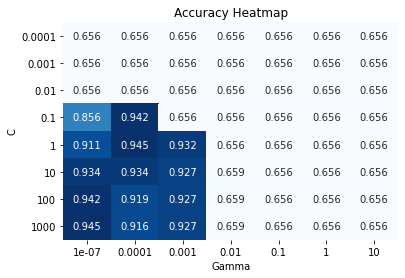

In [75]:
# Heatmap con Gridsearch
parsedMatrix = np.array(gridSearch.cv_results_['mean_test_score']).reshape(8, 7)
sns.heatmap(parsedMatrix, annot=True, cmap='Blues', cbar=False, xticklabels=gamma_values, yticklabels=c_values, fmt=".3")
plt.xlabel('Gamma')
plt.ylabel('C')
plt.title('Accuracy Heatmap')


Vemos que para valores de c  menores a 0.1 la cosa se estanca en valores bajo, asi lo mismo para gamma mayores a 0.01. y el mejor gamma se presenta para c por sobre 0.1 y gamma 0.0001 

## Ejercicio 5: Validación del modelo en el hold-out sample
- Genere las predicciones del hold-out sample en base a la mejor combinación de hiper
parámetros. Genere un reporte con las métricas de desempeño clásicas para los
modelos de clasificación. Comente en qué casos el modelo presenta un desempeño
deficiente.



In [61]:
print(classification_report(y_test, gridSearch.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94        90
           1       0.88      0.92      0.90        53

    accuracy                           0.92       143
   macro avg       0.91      0.92      0.92       143
weighted avg       0.92      0.92      0.92       143



Vemos que el modelo es mejor identificando tumores benignos que malignos debido a la diferencia de precisión. Ambas clases tienen el mismo recall lo que indica que el modelo identifica correctamente el 92 porciento de los datos.

## Ejercicio (opcional): Depuración de atributos
- Reentrene el modelo en función de los atributos que presenten un coeficiente de overlap
menor a .45.
- Reporte el desempeño del modelo y comente sobre los nuevos hiper parámetros
estimados, así como su desempeño en comparación al modelo del ejercicio 5.